In [8]:
import pandas as pd
import os
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Load baseline data from 2022-23 season
df = pd.read_csv('CSV/NBA Stats 202223 Team Metrics Away-Home-Last 5 Splits.csv')
selected_features = ['GP', 'PPG', 'oPPG', 'pDIFF', 'W', 'L', 'WIN%', 'eWIN%']
df = df[selected_features]
print(f"Baseline data shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")
df.head()

Baseline data shape: (30, 8)
Features: ['GP', 'PPG', 'oPPG', 'pDIFF', 'W', 'L', 'WIN%', 'eWIN%']


,GP,PPG,oPPG,pDIFF,W,L,WIN%,eWIN%
0,82,116.9,113.3,3.6,58,24,0.707,0.595
1,82,117.9,111.4,6.5,57,25,0.695,0.677
2,82,115.2,110.9,4.3,54,28,0.659,0.629
3,82,112.3,106.9,5.4,51,31,0.622,0.667
4,82,116.0,113.1,2.9,47,35,0.573,0.589


In [9]:
def prepare_team_data(csv_path, selected_features):
    """
    Load and prepare team game data from CSV.
    
    Args:
        csv_path: Path to the CSV file with game stats
        selected_features: List of features to include
        
    Returns:
        DataFrame with prepared team metrics
    """
    test = pd.read_csv(csv_path)
    df_prepared = pd.DataFrame()
    df_prepared['GP'] = test['Win'] + test['Loss']
    df_prepared['PPG'] = test['PTS']
    df_prepared['oPPG'] = test.iloc[::-1]['PTS'].values
    df_prepared['pDIFF'] = (df_prepared['PPG'] - df_prepared['oPPG']) / df_prepared['GP']
    df_prepared['W'] = test['Win']
    df_prepared['L'] = test['Loss']
    df_prepared['WIN%'] = df_prepared['W'] / df_prepared['GP']
    return df_prepared

def predict_game(model, team_data, team_names=['Nuggets', 'Heat'], game_name=""):
    """
    Make predictions for a game and print normalized probabilities.
    
    Args:
        model: Trained RandomForest model
        team_data: DataFrame with team metrics for the game
        team_names: List of team names
        game_name: Name/description of the game
        
    Returns:
        Dictionary with normalized predictions
    """
    predictions = model.predict(team_data)
    normalized = predictions / predictions.sum() * 100
    
    results = {}
    for i, team in enumerate(team_names):
        results[team] = normalized[i]
        print(f"Probability of {team} Winning {game_name}: {normalized[i]:.2f}%")
    
    return results, predictions

In [10]:
# Prepare features and target (regression on eWIN%)
X = df.drop(columns='eWIN%')
y = df['eWIN%'] * 100  # keep same target scale as before

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Numeric columns (all in this dataset)
numeric_cols = X.columns.tolist()

# Preprocessing pipeline for numeric data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols)
])

# Full pipeline with RandomForestRegressor
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('reg', RandomForestRegressor(random_state=42))
])

# Hyperparameter distribution for RandomizedSearch
param_dist = {
    'reg__n_estimators': [100, 200, 400, 800],
    'reg__max_depth': [None, 5, 10, 20],
    'reg__min_samples_split': [2, 5, 10],
    'reg__min_samples_leaf': [1, 2, 4]
}

# Cross-validation and Randomized Search
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print('Starting hyperparameter search...')
search.fit(X_train, y_train)

print('\nBest parameters:')
print(search.best_params_)

# Evaluate best model on test set
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance on Test Set (best estimator):")
print(f"  Mean Squared Error: {mse:.4f}")
print(f"  R² Score: {r2:.4f}")

# Save the trained pipeline
os.makedirs('models', exist_ok=True)
model_path = Path('models/team_pipeline_regressor.joblib')
joblib.dump(best_model, model_path)
print(f"Saved best model pipeline to: {model_path}")

Starting hyperparameter search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters:
{'reg__n_estimators': 200, 'reg__min_samples_split': 2, 'reg__min_samples_leaf': 1, 'reg__max_depth': 10}
Model Performance on Test Set (best estimator):
  Mean Squared Error: 1.3019
  R² Score: 0.9701
Saved best model pipeline to: models\team_pipeline_regressor.joblib

Best parameters:
{'reg__n_estimators': 200, 'reg__min_samples_split': 2, 'reg__min_samples_leaf': 1, 'reg__max_depth': 10}
Model Performance on Test Set (best estimator):
  Mean Squared Error: 1.3019
  R² Score: 0.9701
Saved best model pipeline to: models\team_pipeline_regressor.joblib


In [11]:
# Define all game CSV files and make predictions
games = {
    'Game 3': 'CSV/NBA Finals Team Stats_Current (games 1&2).csv',
    'Game 4': 'CSV/NBA Finals Team Stats_Current (games 1,2 &3).csv',
    'Game 5': 'CSV/NBA Finals Team Stats_Current (games 1-4).csv'
}

all_predictions = {}

for game_name, csv_path in games.items():
    team_data = prepare_team_data(csv_path, selected_features[:-1])  # Exclude target variable
    results, predictions = predict_game(model, team_data, game_name=game_name)
    all_predictions[game_name] = {'results': results, 'predictions': predictions}
    print()

Probability of Nuggets Winning Game 3: 53.78%
Probability of Heat Winning Game 3: 46.22%

Probability of Nuggets Winning Game 4: 58.52%
Probability of Heat Winning Game 4: 41.48%

Probability of Nuggets Winning Game 5: 58.31%
Probability of Heat Winning Game 5: 41.69%



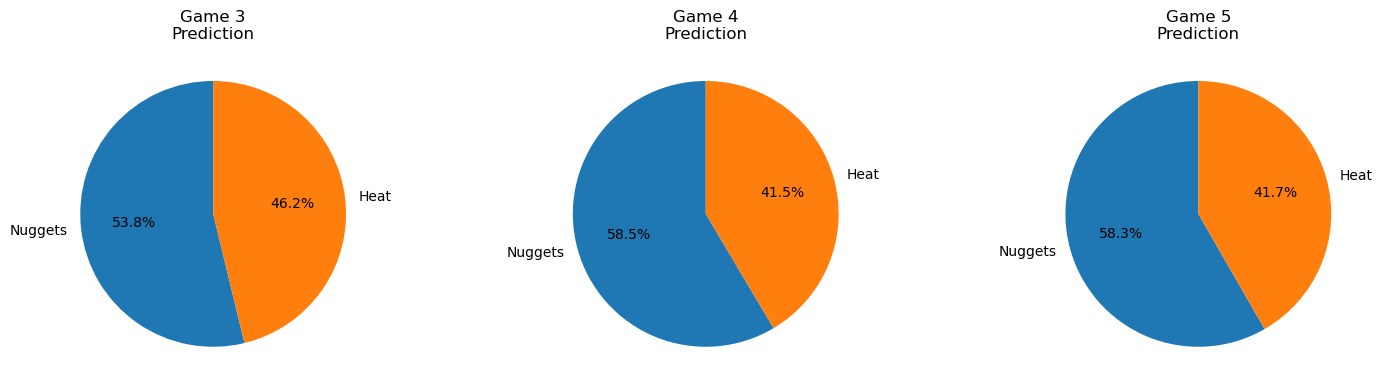

In [12]:
%matplotlib inline

# Create subplots for all game predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (game_name, data) in enumerate(all_predictions.items()):
    results = data['results']
    pred_df = pd.DataFrame([results]).T
    pred_df.columns = ['Win%']
    
    axes[idx].pie(pred_df['Win%'], labels=pred_df.index, autopct='%1.1f%%', startangle=90)
    axes[idx].set_title(f"{game_name}\nPrediction")

plt.tight_layout()
plt.show()